In [15]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install spacy
# !python -m spacy download en_core_web_md
import spacy
from sklearn.preprocessing import normalize
import requests




import warnings
warnings.filterwarnings('ignore')

<!-- ## Data Understanding -->

In [33]:
# Load the dataset
data = pd.read_csv('/workspaces/ML_ZOOMCAMP_2024/video_game_recommender/data/raw/video_game_reviews.csv')

data.columns = [col.lower().replace(' ', '_') for col in data.columns]

# Display the first few rows
data.head()


,game_title,user_rating,age_group_targeted,price,platform,requires_special_device,developer,publisher,release_year,genre,multiplayer,game_length_(hours),graphics_quality,soundtrack_quality,story_quality,user_review_text,game_mode,min_number_of_players
0,Grand Theft Auto V,36.4,All Ages,41.41,PC,No,Game Freak,Innersloth,2015,Adventure,No,55.3,Medium,Average,Poor,"Solid game, but too many bugs.",Offline,1
1,The Sims 4,38.3,Adults,57.56,PC,No,Nintendo,Electronic Arts,2015,Shooter,Yes,34.6,Low,Poor,Poor,"Solid game, but too many bugs.",Offline,3
2,Minecraft,26.8,Teens,44.93,PC,Yes,Bungie,Capcom,2012,Adventure,Yes,13.9,Low,Good,Average,"Great game, but the graphics could be better.",Offline,5
3,Bioshock Infinite,38.4,All Ages,48.29,Mobile,Yes,Game Freak,Nintendo,2015,Sports,No,41.9,Medium,Good,Excellent,"Solid game, but the graphics could be better.",Online,4
4,Half-Life: Alyx,30.1,Adults,55.49,PlayStation,Yes,Game Freak,Epic Games,2022,RPG,Yes,13.2,High,Poor,Good,"Great game, but too many bugs.",Offline,1


In [34]:
# Summary statistics for categorical data
data.describe(include='object')

,game_title,age_group_targeted,platform,requires_special_device,developer,publisher,genre,multiplayer,graphics_quality,soundtrack_quality,story_quality,user_review_text,game_mode
count,47774,47774,47774,47774,47774,47774,47774,47774,47774,47774,47774,47774,47774
unique,40,4,5,2,10,9,10,2,4,4,4,12,2
top,Pokémon Scarlet & Violet,Teens,PlayStation,No,Bungie,Capcom,RPG,No,High,Excellent,Poor,"Great game, but the graphics could be better.",Offline
freq,1274,12038,9633,23887,4877,5406,4873,24090,12113,12036,12041,4067,23957


In [35]:
# Check for missing values
data.isnull().sum()


game_title                 0
user_rating                0
age_group_targeted         0
price                      0
platform                   0
requires_special_device    0
developer                  0
publisher                  0
release_year               0
genre                      0
multiplayer                0
game_length_(hours)        0
graphics_quality           0
soundtrack_quality         0
story_quality              0
user_review_text           0
game_mode                  0
min_number_of_players      0
dtype: int64

In [36]:
duplicate_count = data.duplicated(subset=['game_title']).sum()
print(f"\nNumber of Duplicate Rows: {duplicate_count}")


Number of Duplicate Rows: 47734


In [37]:
for col in data.columns:
    unique_values = data[col].nunique()
    print(f"{col}: {unique_values} unique values")

game_title: 40 unique values
user_rating: 392 unique values
age_group_targeted: 4 unique values
price: 4001 unique values
platform: 5 unique values
requires_special_device: 2 unique values
developer: 10 unique values
publisher: 9 unique values
release_year: 14 unique values
genre: 10 unique values
multiplayer: 2 unique values
game_length_(hours): 551 unique values
graphics_quality: 4 unique values
soundtrack_quality: 4 unique values
story_quality: 4 unique values
user_review_text: 12 unique values
game_mode: 2 unique values
min_number_of_players: 9 unique values


In [38]:
# Unique values for each column
for column in ['game_title', 'platform', 'developer', 'publisher', 'genre', 'graphics_quality', 'soundtrack_quality', 'story_quality', 'game_mode']:
    print(f"{column} unique values:\n{data[column].unique()}\n")


game_title unique values:
['Grand Theft Auto V' 'The Sims 4' 'Minecraft' 'Bioshock Infinite'
 'Half-Life: Alyx' 'Sid Meier’s Civilization VI' 'Just Dance 2024'
 '1000-Piece Puzzle' 'Spelunky 2' 'Street Fighter V' 'Fall Guys'
 'Rocket League' 'The Elder Scrolls V: Skyrim' 'Among Us' 'Stardew Valley'
 'Call of Duty: Modern Warfare 2'
 'The Legend of Zelda: Breath of the Wild' 'Tekken 7'
 'Pillars of Eternity II: Deadfire' 'Animal Crossing: New Horizons'
 'Hades' 'Mario Kart 8 Deluxe' 'Overwatch 2' 'Fortnite'
 'Pokémon Scarlet & Violet' 'Hitman 3' 'Tomb Raider (2013)'
 'Halo Infinite' 'Super Smash Bros. Ultimate' 'Kingdom Hearts III'
 'League of Legends' 'The Witcher 3: Wild Hunt' 'FIFA 24'
 'Ghost of Tsushima' 'Cuphead' 'Red Dead Redemption 2' 'Portal 2' 'Tetris'
 'Counter-Strike: Global Offensive' 'Super Mario Odyssey']

platform unique values:
['PC' 'Mobile' 'PlayStation' 'Xbox' 'Nintendo Switch']

developer unique values:
['Game Freak' 'Nintendo' 'Bungie' 'Capcom' 'Epic Games' 'CD Pro

In [40]:
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Correlation analysis for numerical columns
if len(numerical_cols) > 1:
    print("\nCorrelation Matrix for Numerical Columns:")
    correlation = data[numerical_cols].corr()
correlation


Correlation Matrix for Numerical Columns:


,user_rating,price,release_year,game_length_(hours),min_number_of_players
user_rating,1.000000,0.760659,-0.003128,0.628743,-0.000365
price,0.760659,1.000000,-0.005974,-0.002613,0.001908
release_year,-0.003128,-0.005974,1.000000,0.002449,0.011940
game_length_(hours),0.628743,-0.002613,0.002449,1.000000,-0.003122
min_number_of_players,-0.000365,0.001908,0.011940,-0.003122,1.000000


## Exploratory Analysis

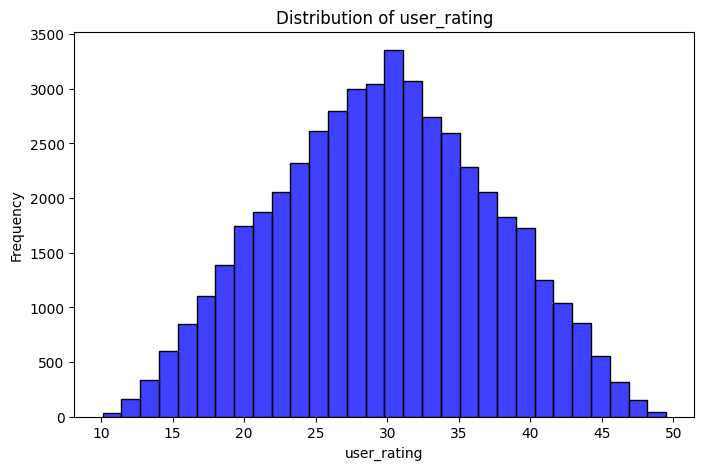

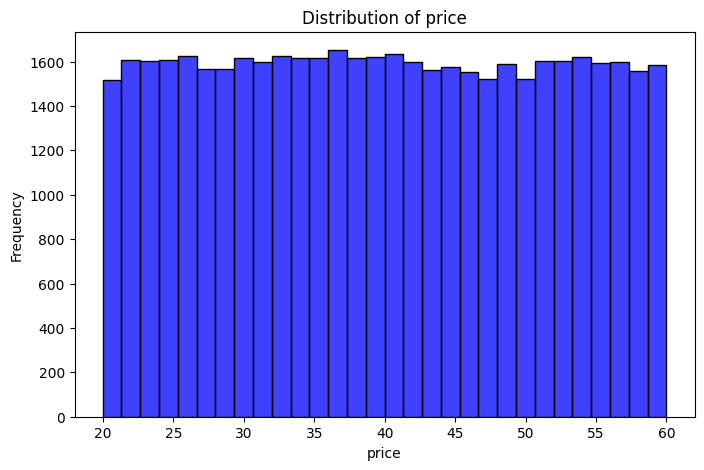

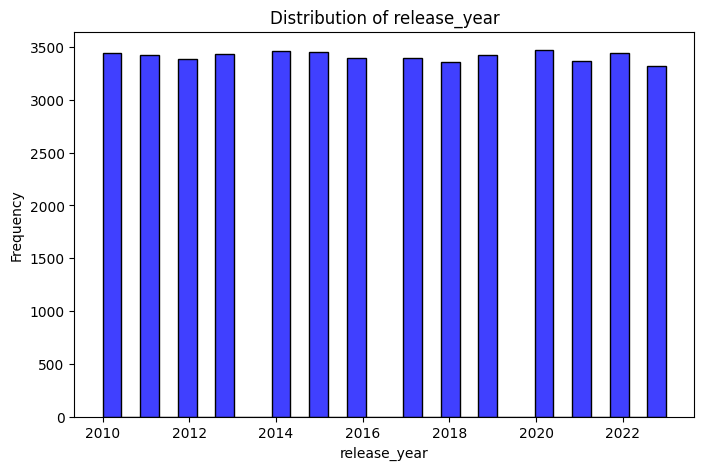

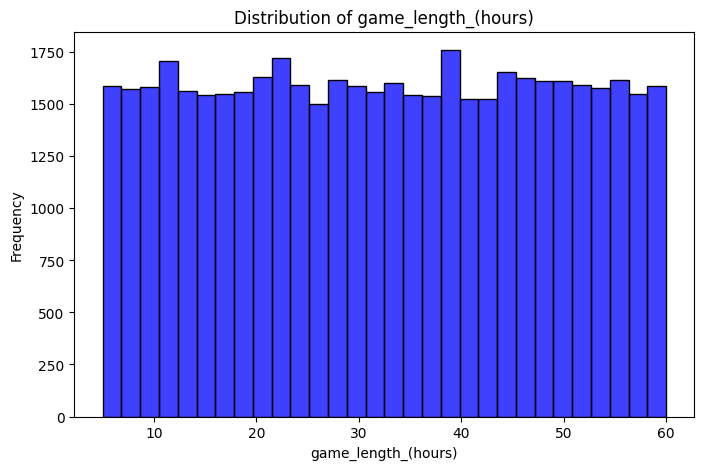

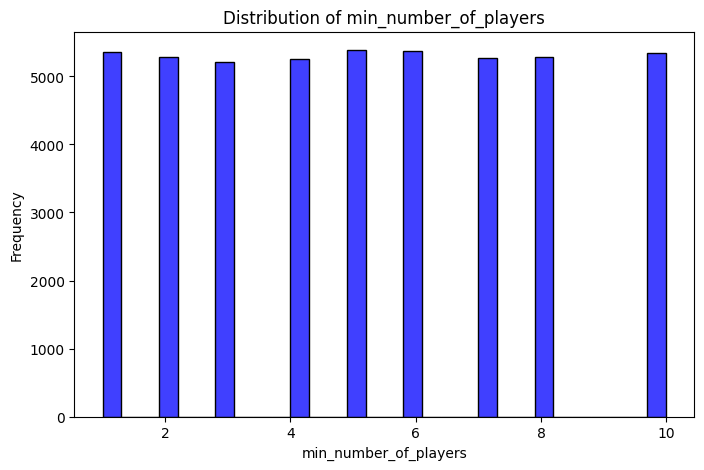

In [41]:
# 1. Distribution of Numerical Features
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[col], bins=30, color='blue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


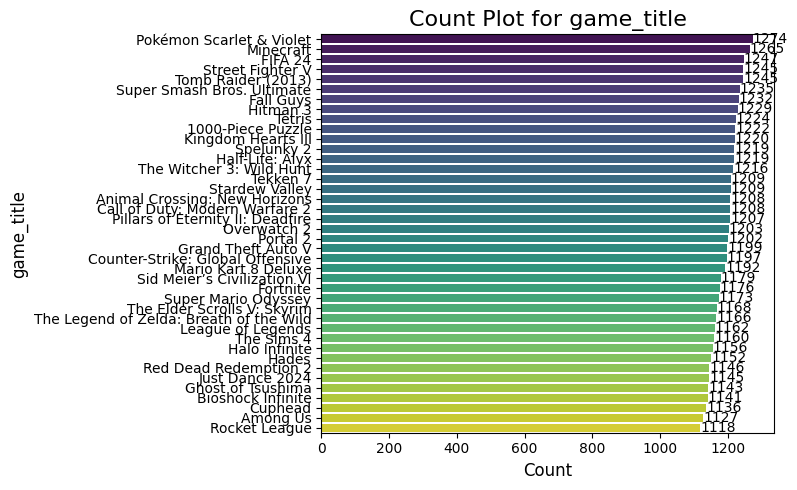

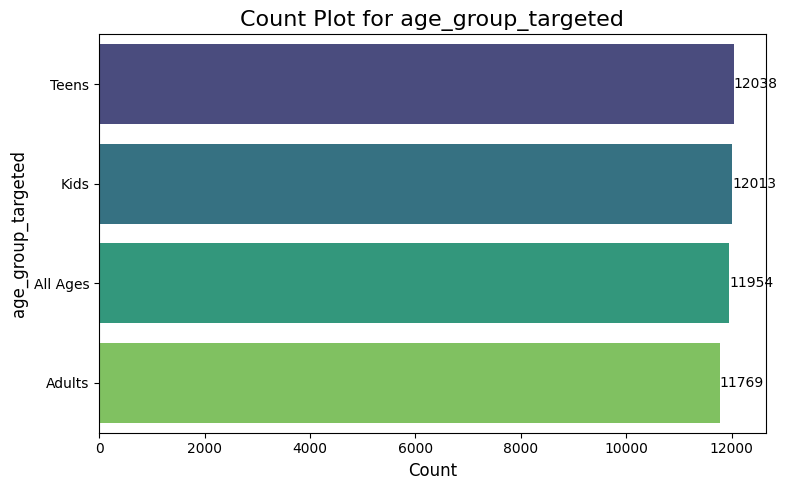

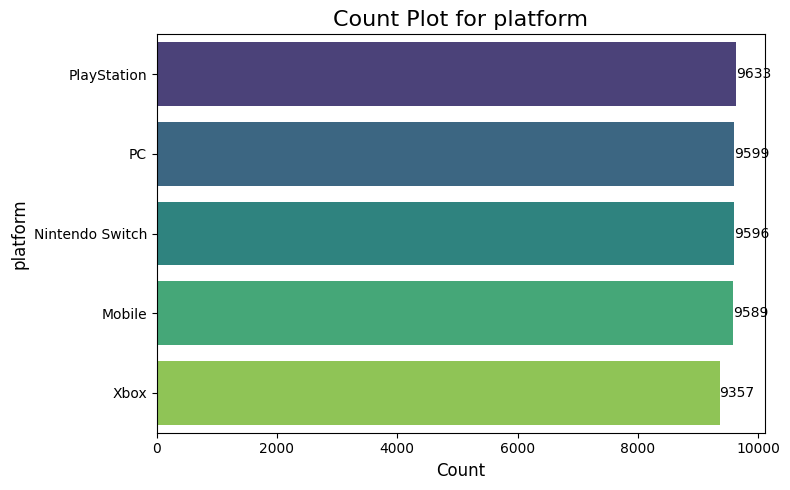

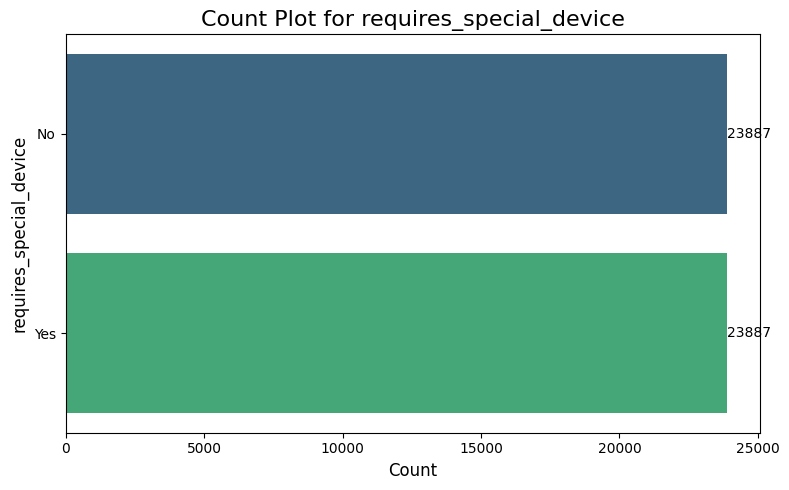

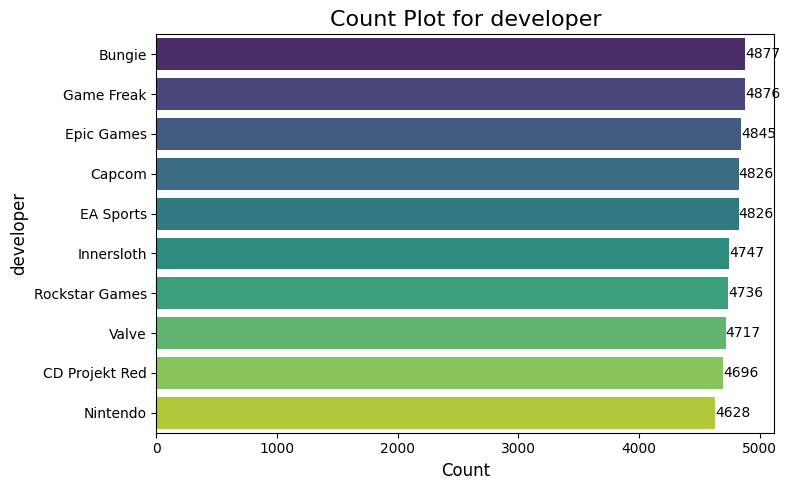

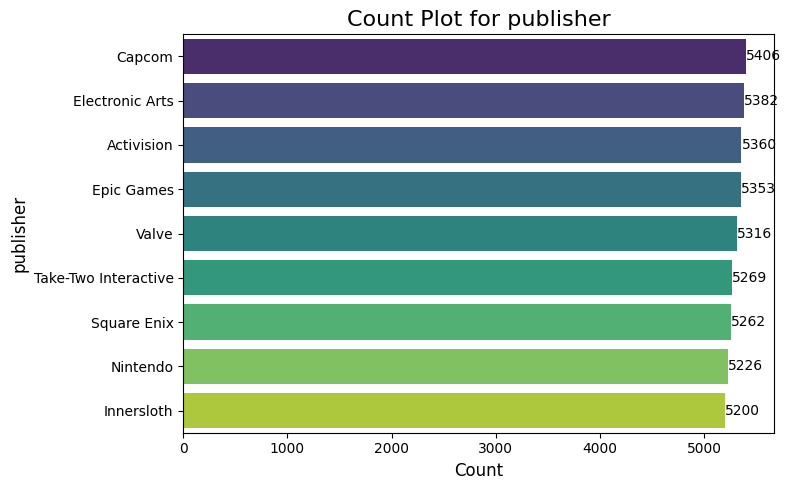

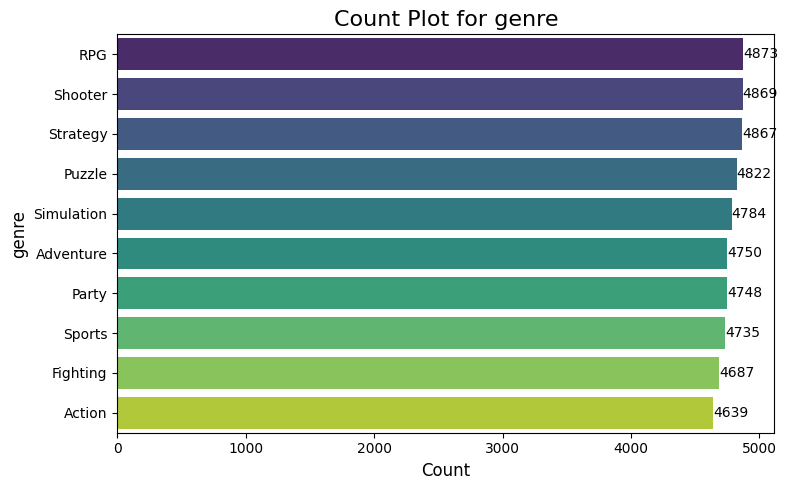

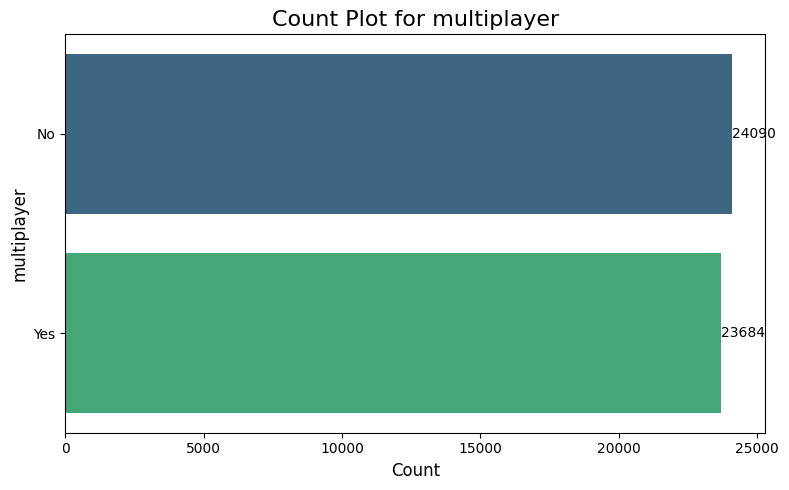

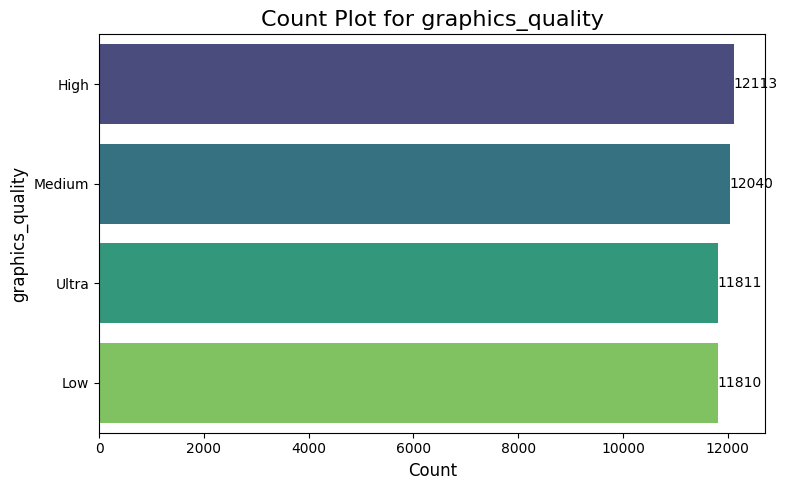

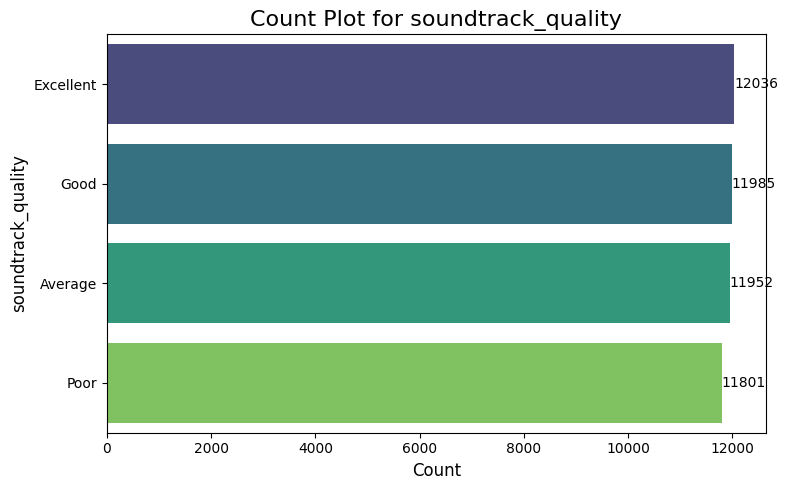

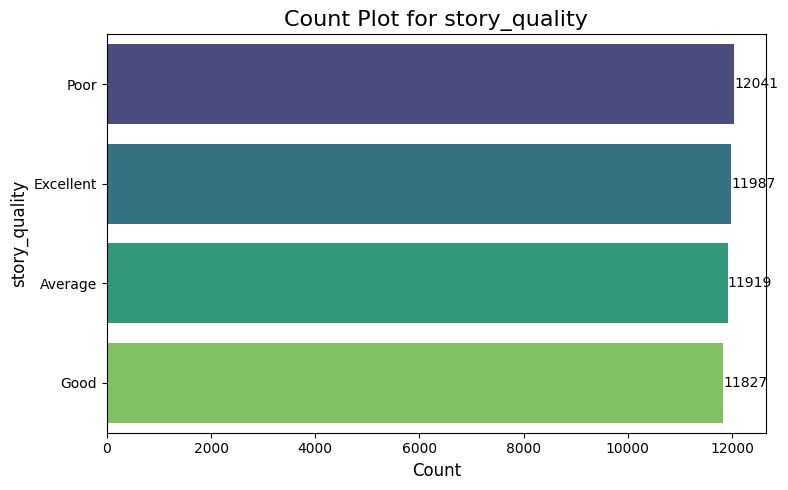

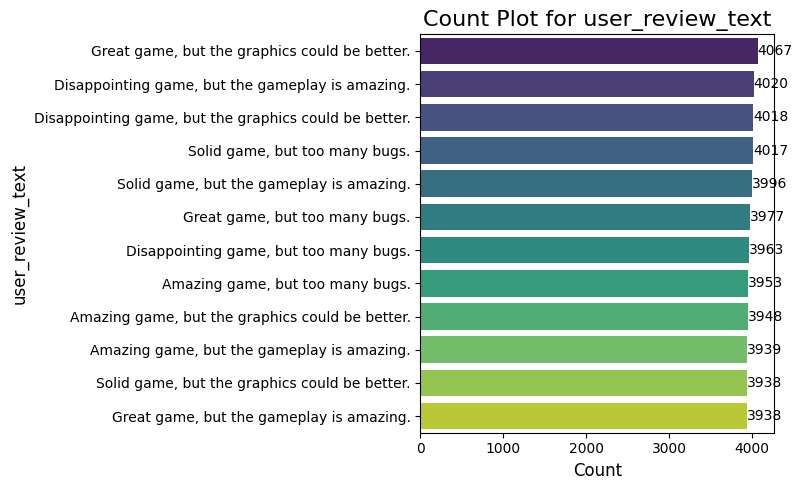

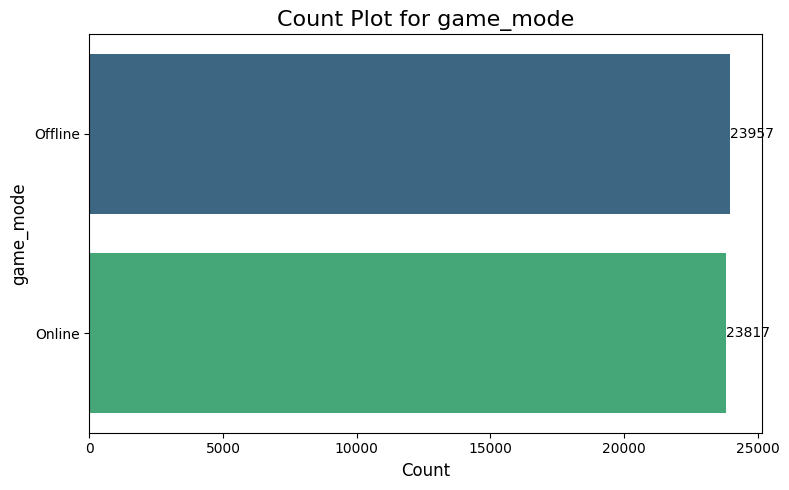

In [42]:
# 2. Count of Categorical Features
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(
        y=data[col],
        order=data[col].value_counts().index,
        palette='viridis'
    )
    plt.title(f"Count Plot for {col}", fontsize=16)
    plt.xlabel("Count", fontsize=12)
    plt.ylabel(col, fontsize=12)

    # Annotate bars
    for p in ax.patches:
        count = p.get_width()  # Get the width of the bar (count value)
        ax.annotate(
            f'{int(count)}',  # Convert count to an integer and format it as a string
            (count, p.get_y() + p.get_height() / 2),  # Position annotation at the end of the bar
            ha='left', va='center',  # Align text horizontally and vertically
            fontsize=10, color='black'  # Set font size and color
        )

    plt.tight_layout()  # Adjust the layout to avoid overlap
    plt.show()  # Display the plot


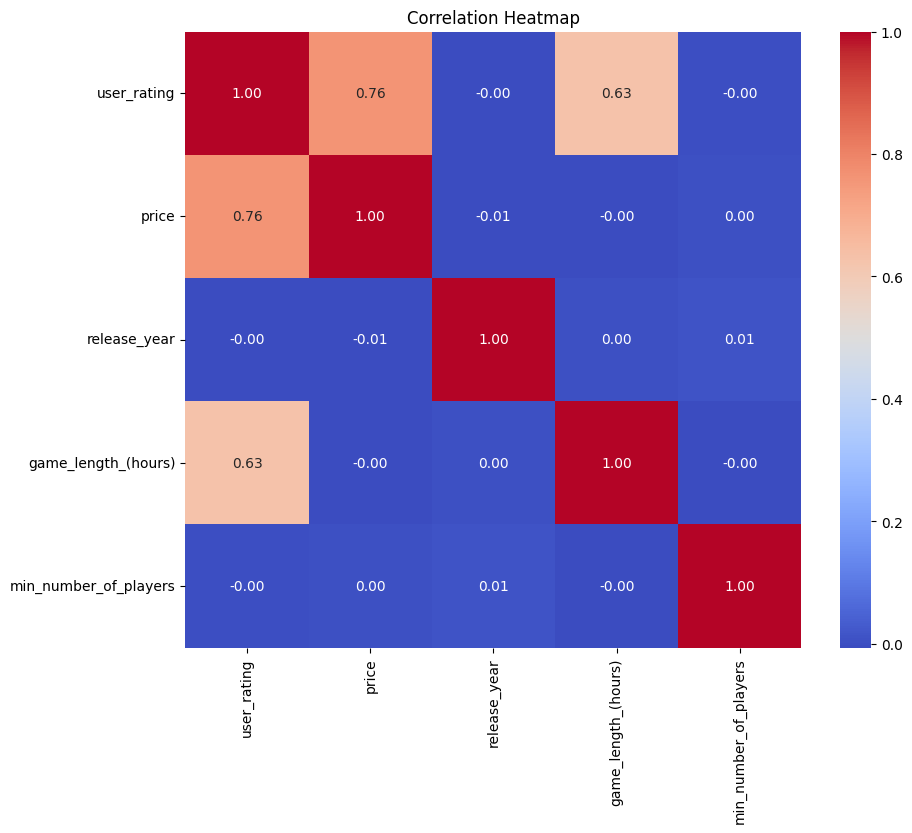

In [43]:
# 3. Correlation Heatmap for Numerical Features
if len(numerical_cols) > 1:
    plt.figure(figsize=(10, 8))
    correlation_matrix = data[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Heatmap")
    plt.show()

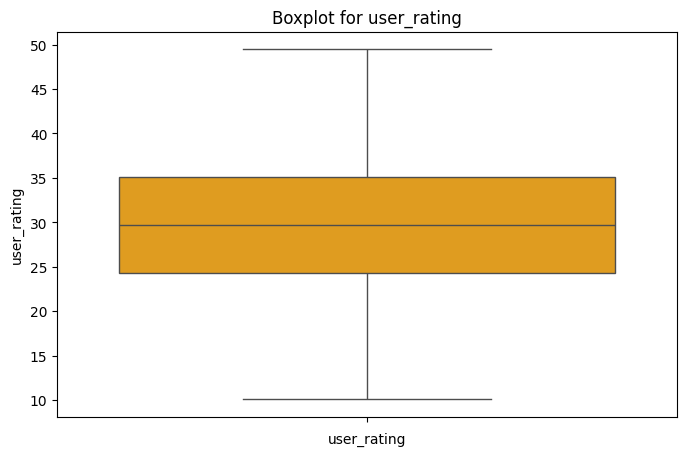

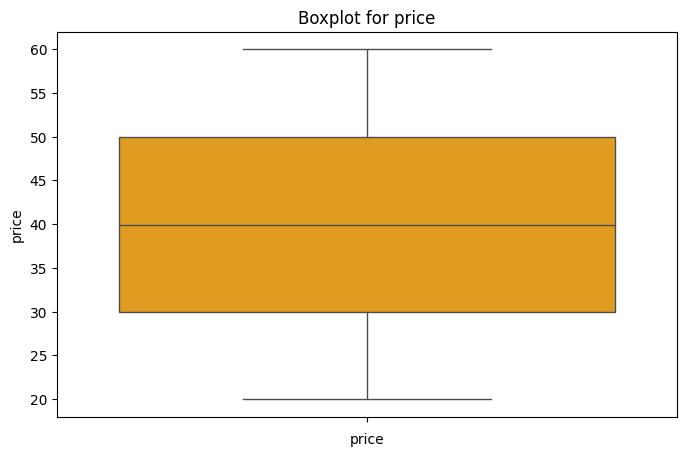

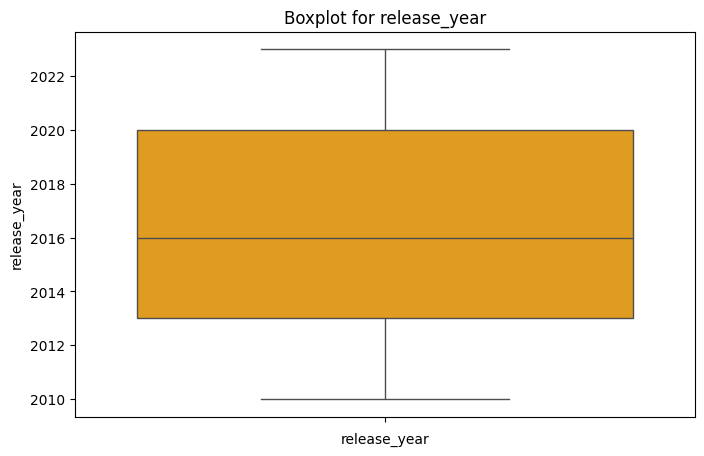

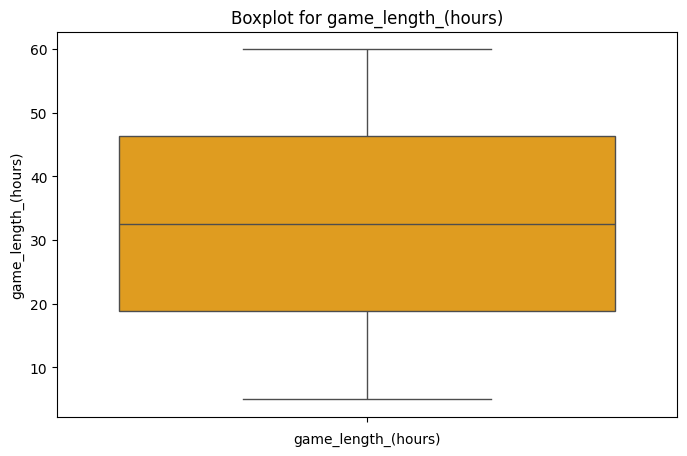

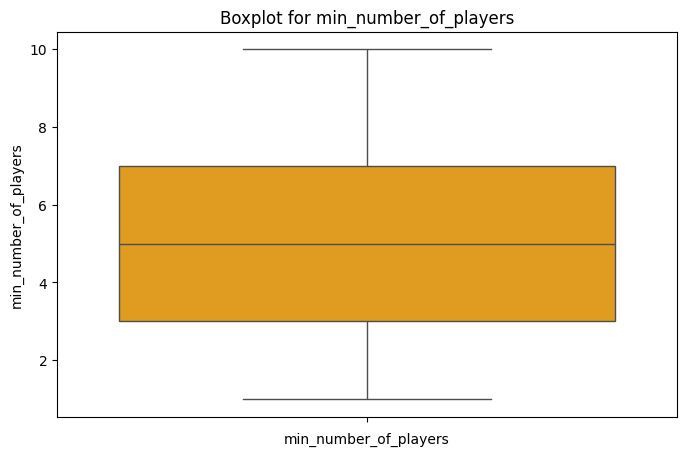

In [44]:
# 4. Boxplots to Identify Outliers
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=data[col], color='orange')
    plt.title(f"Boxplot for {col}")
    plt.xlabel(col)
    plt.show()

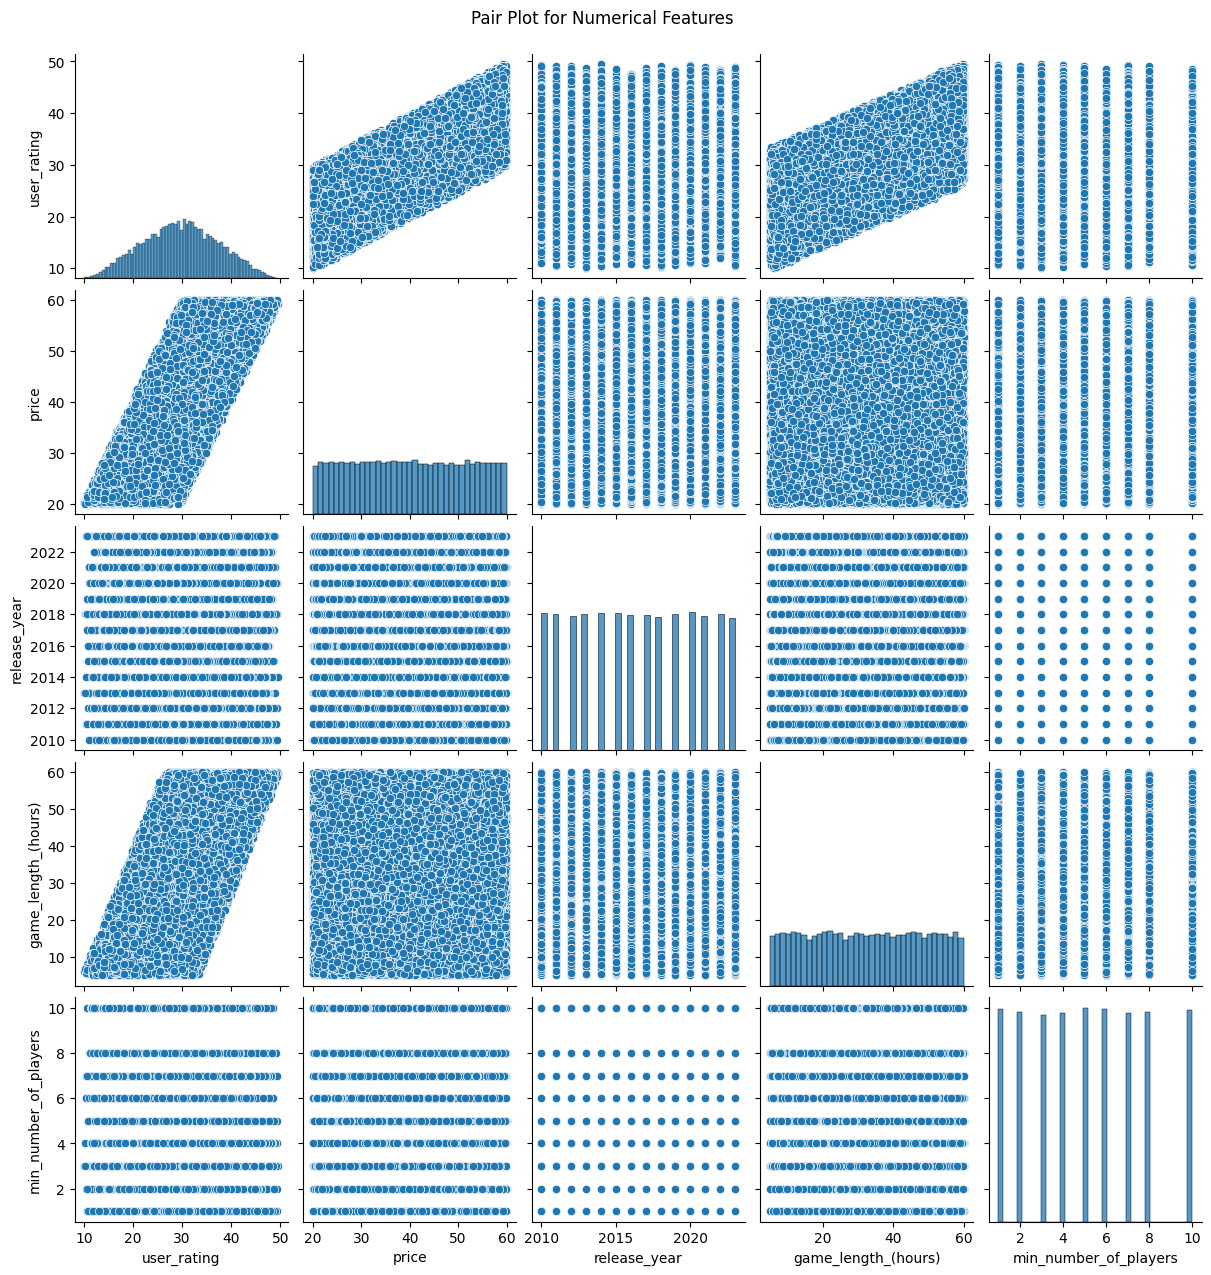

In [27]:
# 5. Pair Plot for Relationships between Numerical Columns
if len(numerical_cols) > 1:
    sns.pairplot(data[numerical_cols])
    plt.suptitle("Pair Plot for Numerical Features", y=1.02)
    plt.show()

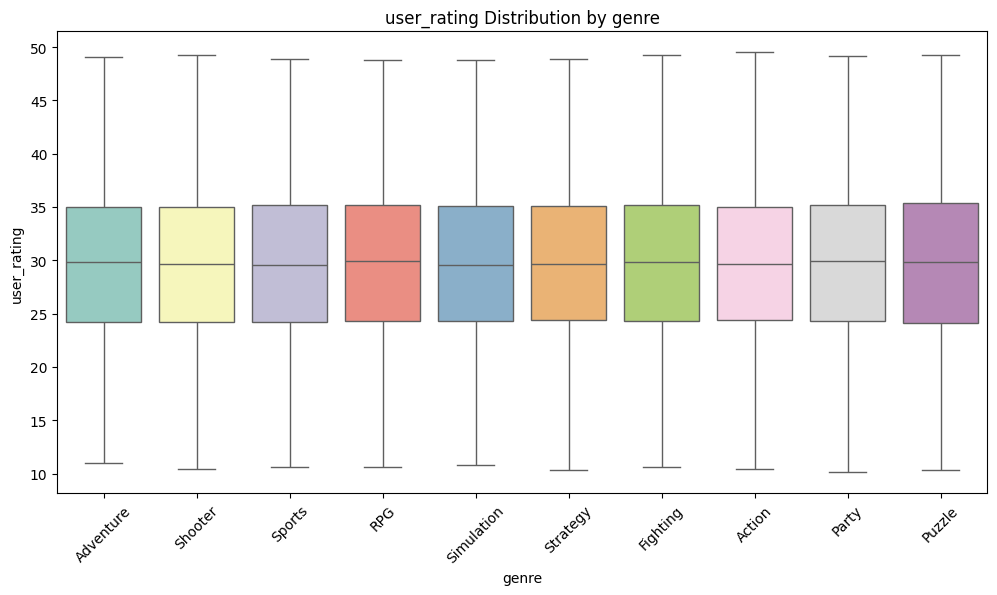

In [28]:
# 6. Distribution of Ratings by Category (e.g., genre)
if 'user_rating' in data.columns and 'genre' in data.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data, x='genre', y='user_rating', palette='Set3')
    plt.xticks(rotation=45)
    plt.title("user_rating Distribution by genre")
    plt.xlabel("genre")
    plt.ylabel("user_rating")
    plt.show()

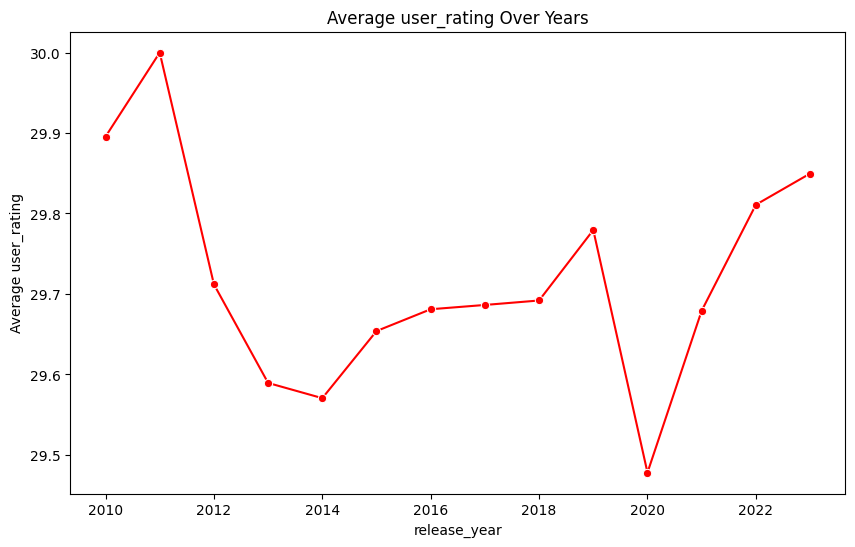

In [29]:
# 7. Trends Over Time (e.g., release_year vs user_rating)
if 'release_year' in data.columns and 'user_rating' in data.columns:
    yearly_ratings = data.groupby('release_year')['user_rating'].mean().reset_index()
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=yearly_ratings, x='release_year', y='user_rating', marker='o', color='red')
    plt.title("Average user_rating Over Years")
    plt.xlabel("release_year")
    plt.ylabel("Average user_rating")
    plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 32.9 MB/s eta 0:00:00


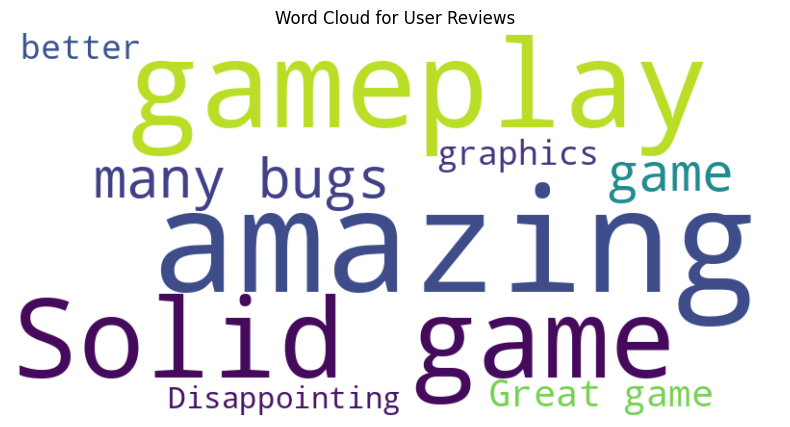

In [ ]:
# 8. Word Cloud for user_review_text
if 'user_review_text' in data.columns:
    from wordcloud import WordCloud

    review_text = " ".join(data['user_review_text'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(review_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud for User Reviews")
    plt.show()

In [46]:
# Bin game_lenghts_(hours) into 10 intervals
if 'game_lenghts_(hours)' in data.columns:
    game_length_bins, game_length_edges = pd.cut(
        data['game_lenghts_(hours)'], bins=10, retbins=True
    )
    data['Game Length Binned'] = game_length_bins  # Store bin intervals in the DataFrame
    game_length_labels = [f'{round(game_length_edges[i], 1)} - {round(game_length_edges[i+1], 1)}'
                          for i in range(len(game_length_edges) - 1)]
    print("Binned game_lenghts_(hours) into 10 intervals.")

# Bin Price into 10 intervals
if 'Price' in data.columns:
    price_bins, price_edges = pd.cut(
        data['Price'], bins=10, retbins=True
    )
    data['Price Binned'] = price_bins  # Store bin intervals in the DataFrame
    price_labels = [f'{round(price_edges[i], 1)} - {round(price_edges[i+1], 1)}'
                    for i in range(len(price_edges) - 1)]
    print("Binned Price into 10 intervals.")

In [23]:
# Define a function to create annotated bar plots
def bar_plot(data, x_col, y_col, title, xlabel, ylabel, rotation=0, figsize=(10, 6), xtick_labels=None):
    """
    Creates a bar plot for visualizing the relationship between two columns with bar annotations.

    Parameters:
    - data: DataFrame containing the data
    - x_col: Column to plot on the x-axis
    - y_col: Column to plot on the y-axis
    - title: Title of the plot
    - xlabel: Label for the x-axis
    - xtick_labels: Customizes the x-axis labels
    - ylabel: Label for the y-axis
    - rotation: Degree of rotation for x-axis labels (default: 0)
    - figsize: Tuple specifying figure size (default: (10, 6))
    """
    plt.figure(figsize=figsize)
    ax = sns.barplot(data=data, x=x_col, y=y_col, ci=None, palette="viridis")  # ci=None disables confidence intervals
    plt.title(title, fontsize=16)  # Set plot title
    plt.xlabel(xlabel, fontsize=12)  # Set x-axis label
    plt.ylabel(ylabel, fontsize=12)  # Set y-axis label
    plt.xticks(rotation=rotation, fontsize=10)  # Rotate x-axis labels if needed

    # Annotate bars
    for p in ax.patches:
        height = p.get_height()  # Get the height of the bar
        if not pd.isna(height):  # Only annotate bars with valid heights
            ax.annotate(f'{height:.2f}',  # Format height to two decimal places
                        (p.get_x() + p.get_width() / 2., height),  # Position annotation at the center of the bar
                        ha='center', va='bottom',  # Align text horizontally and vertically
                        fontsize=10, color='black')  # Set font size and color

    plt.show()

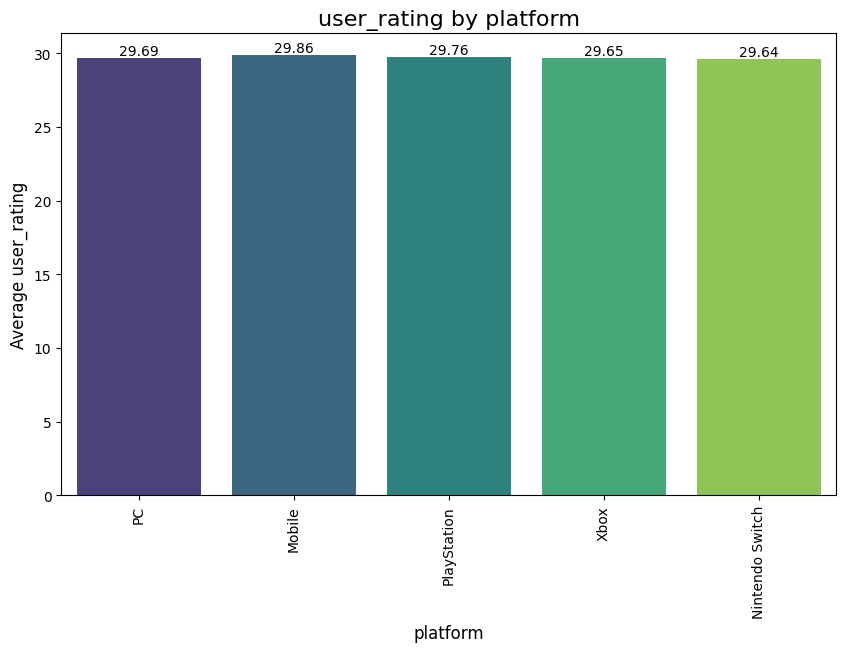

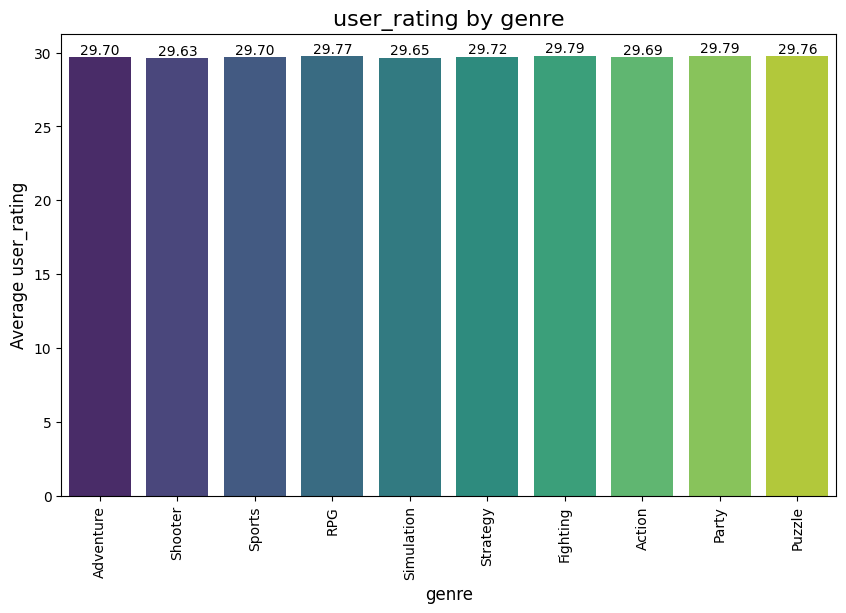

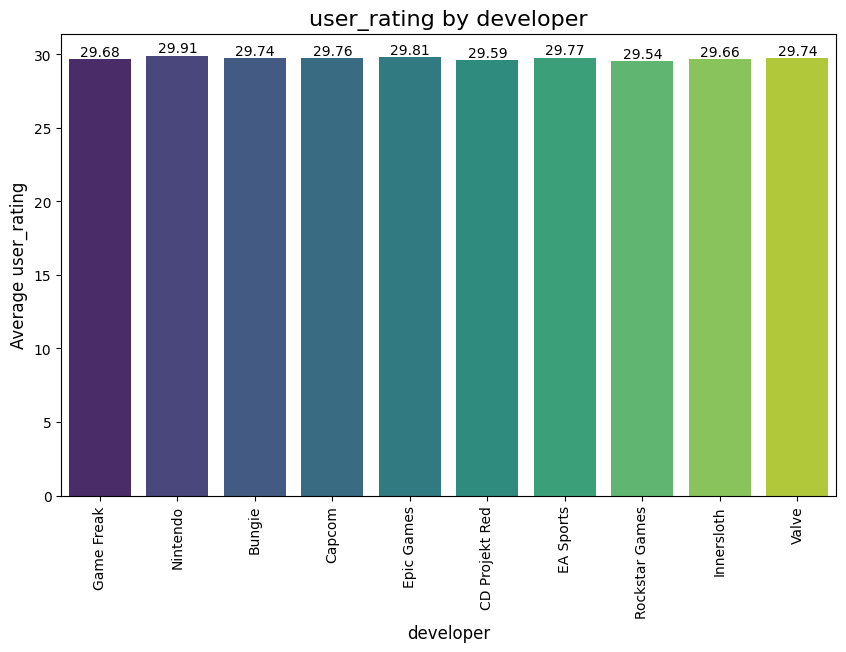

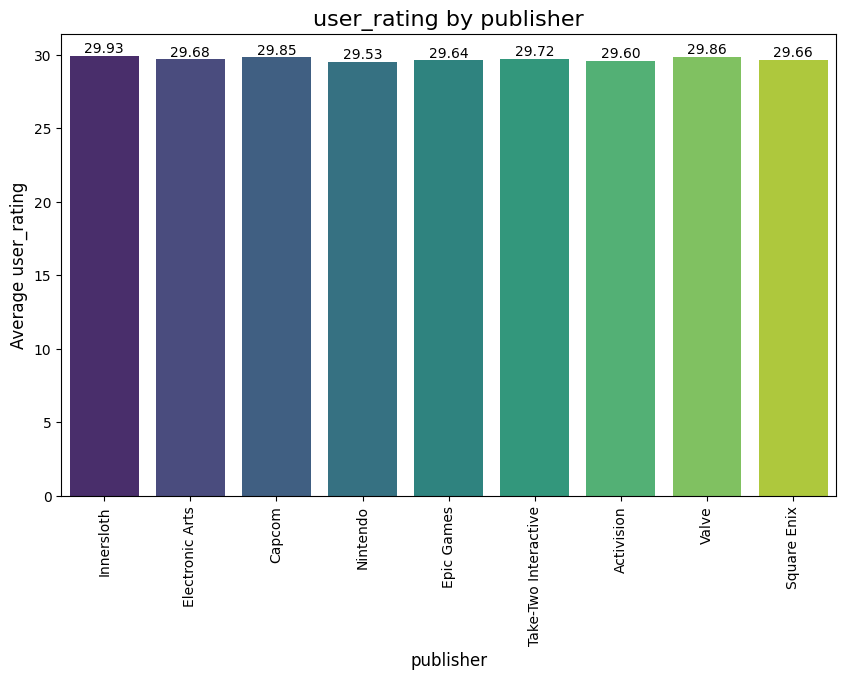

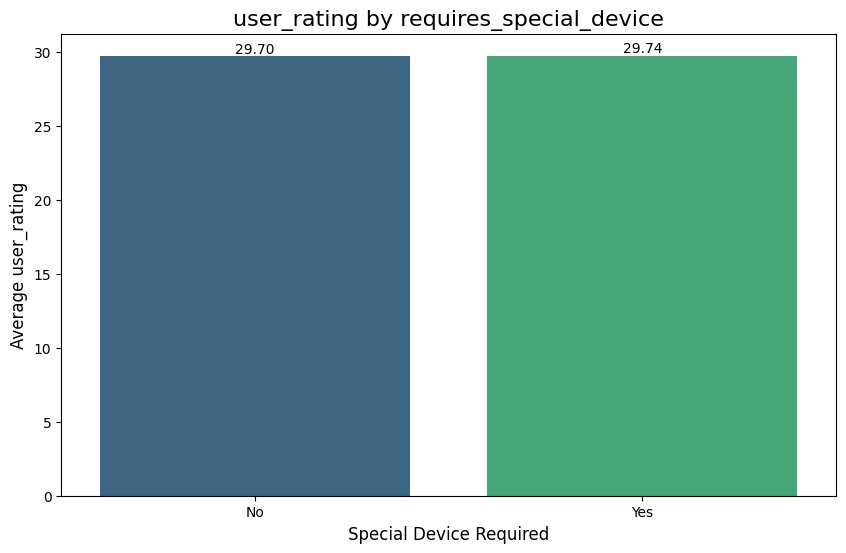

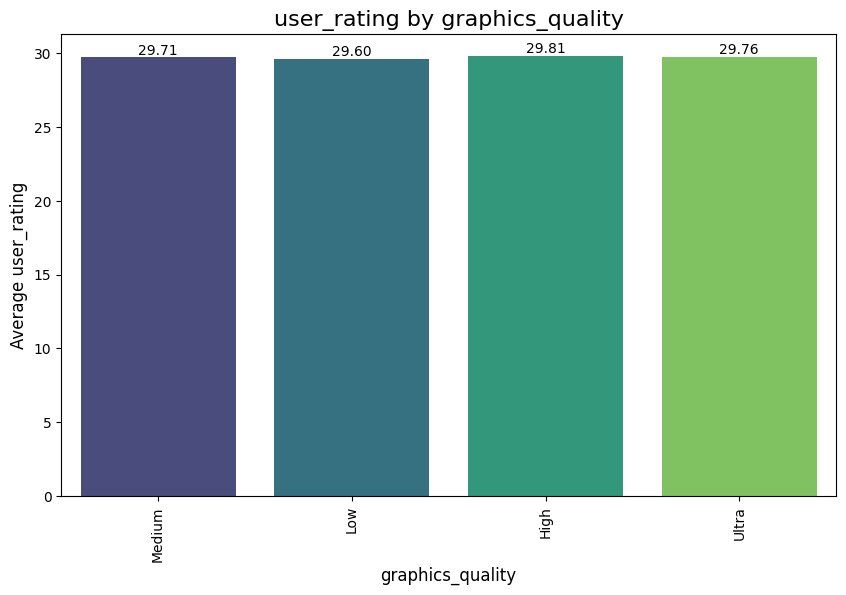

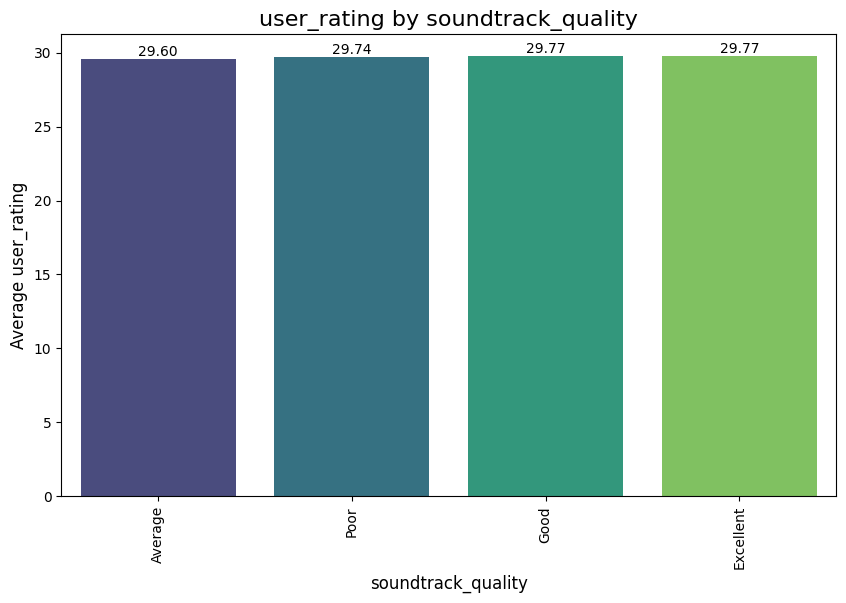

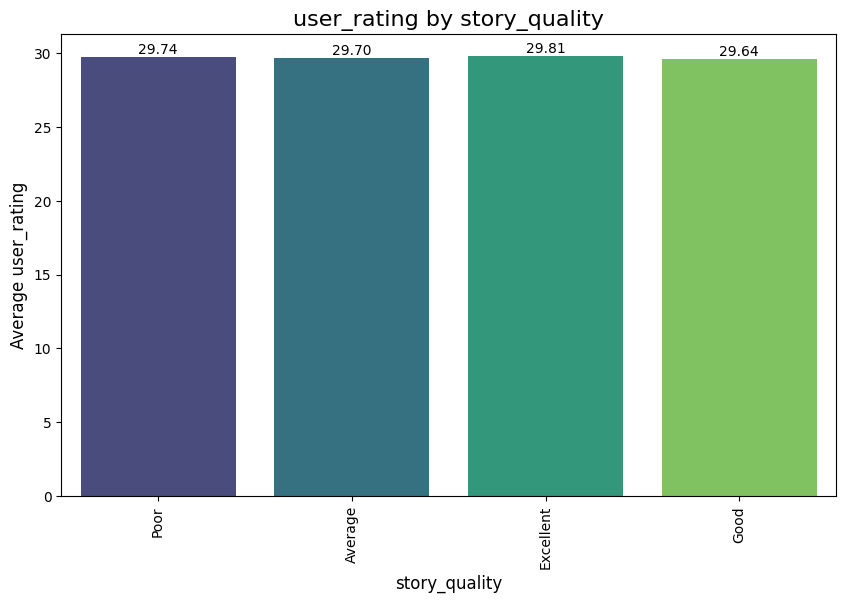

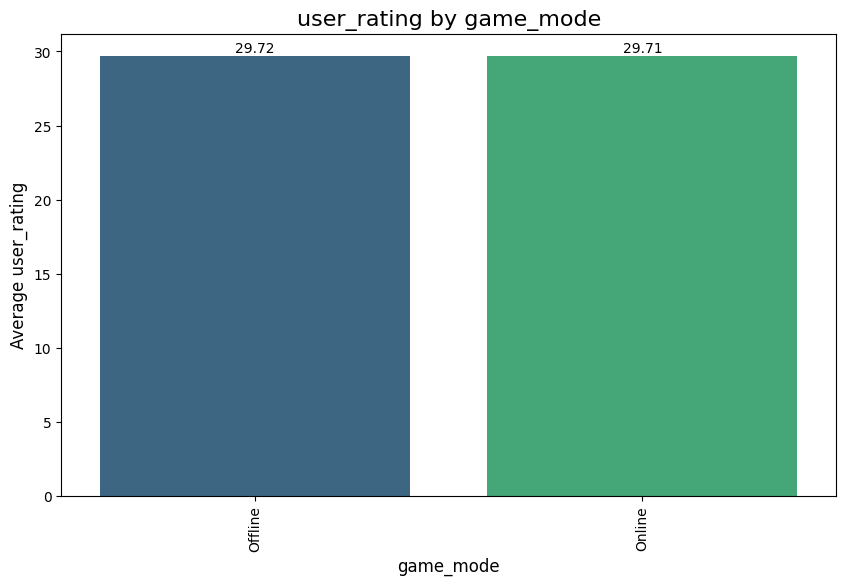

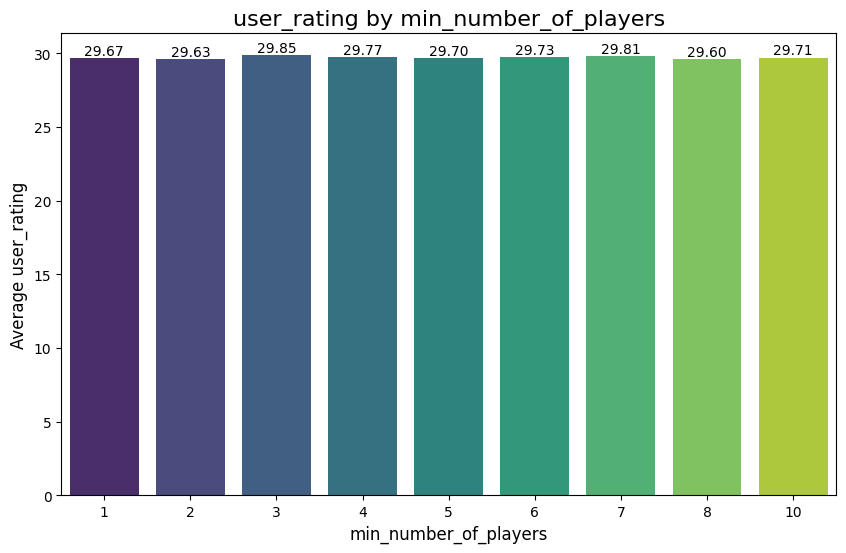

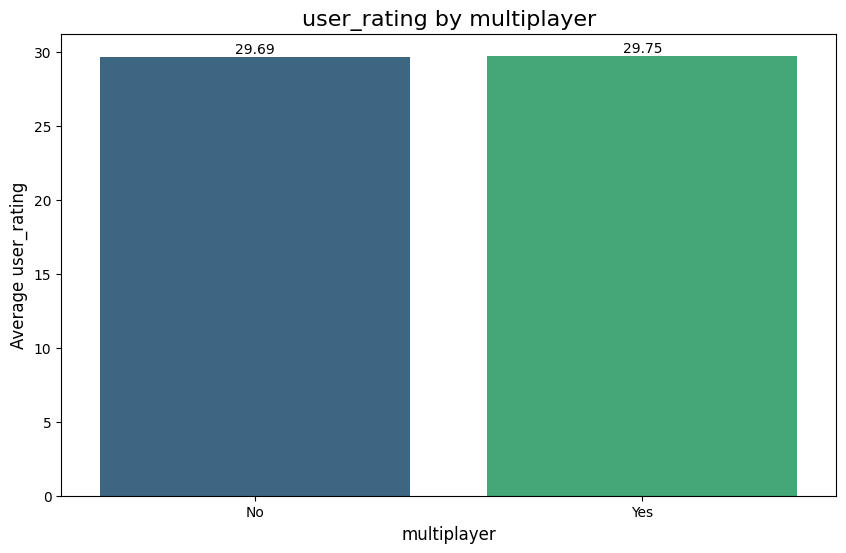

In [24]:
# user_rating ANALYSIS
# Exploring how user_rating varies with different attributes

# user_rating by Age Group
if 'user_rating' in data.columns and 'age_goup_targeted' in data.columns:
    bar_plot(data, 'age_goup_targeted', 'user_rating',
             "user_rating by Age Group", "Age Group", "Average user_rating")

# user_rating by platform
if 'user_rating' in data.columns and 'platform' in data.columns:
    bar_plot(data, 'platform', 'user_rating',
             "user_rating by platform", "platform", "Average user_rating", rotation=90)  # Rotate x-axis labels

# user_rating by genre
if 'user_rating' in data.columns and 'genre' in data.columns:
    bar_plot(data, 'genre', 'user_rating',
             "user_rating by genre", "genre", "Average user_rating", rotation=90)

# user_rating by developer/publisher
# Separate plots for developer and publisher
if 'user_rating' in data.columns and 'developer' in data.columns:
    bar_plot(data, 'developer', 'user_rating',
             "user_rating by developer", "developer", "Average user_rating", rotation=90)

if 'user_rating' in data.columns and 'publisher' in data.columns:
    bar_plot(data, 'publisher', 'user_rating',
             "user_rating by publisher", "publisher", "Average user_rating", rotation=90)

# user_rating by requires_special_device
if 'user_rating' in data.columns and 'requires_special_device' in data.columns:
    bar_plot(data, 'requires_special_device', 'user_rating',
             "user_rating by requires_special_device", "Special Device Required", "Average user_rating")

# user_rating by Graphics/Soundtrack/Story Quality
# Iterate through related columns for compact code
for col in ['graphics_quality', 'soundtrack_quality', 'story_quality']:
    if 'user_rating' in data.columns and col in data.columns:
        bar_plot(data, col, 'user_rating',
                 f"user_rating by {col}", col, "Average user_rating", rotation=90)

# user_rating by game_mode
if 'user_rating' in data.columns and 'game_mode' in data.columns:
    bar_plot(data, 'game_mode', 'user_rating',
             "user_rating by game_mode", "game_mode", "Average user_rating", rotation=90)

# user_rating by min_number_of_players
if 'user_rating' in data.columns and 'min_number_of_players' in data.columns:
    bar_plot(data, 'min_number_of_players', 'user_rating',
             "user_rating by min_number_of_players", "min_number_of_players", "Average user_rating")

# user_rating by multiplayer
if 'user_rating' in data.columns and 'multiplayer' in data.columns:
    bar_plot(data, 'multiplayer', 'user_rating',
             "user_rating by multiplayer", "multiplayer", "Average user_rating")

# user_rating by relaease_year
if 'user_rating' in data.columns and 'relaease_year' in data.columns:
    bar_plot(data, 'relaease_year', 'user_rating',
             "user_rating by relaease_year", "relaease_year", "Average user_rating")

# user_rating by Binned Game Length
if 'user_rating' in data.columns and 'game_length_binned' in data.columns:
    bar_plot(
        data, 'game_length_binned', 'user_rating',
        "user_rating by Binned Game Length", "Binned Game Length", "Average user_rating",
        rotation=90, xtick_labels=game_length_labels
    )

# user_rating by Binned Price
if 'user_rating' in data.columns and 'price_binned' in data.columns:
    bar_plot(
        data, 'price_binned', 'user_rating',
        "user_rating by Binned Price", "Binned Price", "Average user_rating",
        rotation=90, xtick_labels=price_labels
    )


In [47]:
# PRICE ANALYSIS
# Exploring how Price varies with different attributes

# Price by Age Group
if 'Price' in data.columns and 'Age Group Targeted' in data.columns:
    bar_plot(data, 'Age Group Targeted', 'Price',
             "Price by Age Group", "Age Group", "Average Price")

# Price by Platform
if 'Price' in data.columns and 'Platform' in data.columns:
    bar_plot(data, 'Platform', 'Price',
             "Price by Platform", "Platform", "Average Price", rotation=90)

# Price by Genre
if 'Price' in data.columns and 'Genre' in data.columns:
    bar_plot(data, 'Genre', 'Price',
             "Price by Genre", "Genre", "Average Price", rotation=90)

# Price by Requires Special Device
if 'Price' in data.columns and 'Requires Special Device' in data.columns:
    bar_plot(data, 'Requires Special Device', 'Price',
             "Price by Requires Special Device", "Special Device Required", "Average Price")

# Price by Developer/Publisher
# Separate plots for Developer and Publisher
if 'Price' in data.columns and 'Developer' in data.columns:
    bar_plot(data, 'Developer', 'Price',
             "Price by Developer", "Developer", "Average Price", rotation=90)

if 'Price' in data.columns and 'Publisher' in data.columns:
    bar_plot(data, 'Publisher', 'Price',
             "Price by Publisher", "Publisher", "Average Price", rotation=90)

# Price by Release Year
if 'Price' in data.columns and 'Release Year' in data.columns:
    bar_plot(data, 'Release Year', 'Price',
             "Price by Release Year", "Release Year", "Average Price")

# Price by Multiplayer
if 'Price' in data.columns and 'Multiplayer' in data.columns:
    bar_plot(data, 'Multiplayer', 'Price',
             "Price by Multiplayer", "Multiplayer", "Average Price")
# Price by Binned Game Length
if 'Price' in data.columns and 'Game Length Binned' in data.columns:
    bar_plot(
        data, 'Game Length Binned', 'User Rating',
        "Price by Binned Game Length", "Binned Game Length", "Average Price",
        rotation=90, xtick_labels=game_length_labels
    )

# Price by Binned Price
if 'Price' in data.columns and 'Price Binned' in data.columns:
    bar_plot(
        data, 'Price Binned', 'Price',
        "Price by Binned Price", "Binned Price", "Average Price",
        rotation=90, xtick_labels=price_labels
    )


## Data Preprocessing

In [63]:
print(data.duplicated(subset='game_title').sum())

print("From Data Understanding above, it's seen that there are no missing values, duplicates, data is relatively normally distributed")

13
From Data Understanding above, it's seen that there are no missing values, duplicates, data is relatively normally distributed


### Create Item Profiles

In [49]:
# Initialize an empty string for the combined features
data['combined_features'] = ''

# Loop through the categorical columns to combine features
for col in categorical_cols:
    data['combined_features'] += data[col].astype(str) + ' '  # Convert to string and concatenate

# Include numerical features in the combined features (optional: scale or normalize if needed)
data['combined_features'] += 'Rating_' + data['user_rating'].astype(str) + ' ' + \
                             'Price_' + data['price'].astype(str) + ' '

# Remove duplicates based on 'game_title'
data = data.drop_duplicates(subset=['game_title'])

# Display the updated DataFrame
print(data[['combined_features']])

                                     combined_features
0    Grand Theft Auto V All Ages PC No Game Freak I...
1    The Sims 4 Adults PC No Nintendo Electronic Ar...
2    Minecraft Teens PC Yes Bungie Capcom Adventure...
3    Bioshock Infinite All Ages Mobile Yes Game Fre...
4    Half-Life: Alyx Adults PlayStation Yes Game Fr...
6    Sid Meier’s Civilization VI Adults Mobile No G...
7    Just Dance 2024 Teens Nintendo Switch No Capco...
9    1000-Piece Puzzle Kids PC No CD Projekt Red In...
10   Spelunky 2 Adults Mobile No Capcom Capcom Adve...
11   Street Fighter V All Ages PlayStation No Game ...
13   Fall Guys Teens Nintendo Switch Yes Capcom Epi...
15   Rocket League Kids PlayStation No Epic Games V...
16   The Elder Scrolls V: Skyrim All Ages PC No Epi...
17   Among Us Teens Mobile No Epic Games Activision...
19   Stardew Valley Kids Mobile Yes Bungie Take-Two...
21   Call of Duty: Modern Warfare 2 All Ages PC No ...
22   The Legend of Zelda: Breath of the Wild Adults...
23   Tekke

In [51]:
# Load the spaCy model
nlp = spacy.load('en_core_web_md')

# Combined text cleaning and vectorization function
def clean_and_vectorize(text):
    # Process the text using spaCy
    doc = nlp(text)
    # Lemmatize and remove stop words and punctuation
    cleaned_text = ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
    # Return both cleaned text and vector
    return cleaned_text, doc.vector

# Apply the cleaning and vectorization function to the dataset
data[['cleaned_combined_features', 'combined_features_vector']] = data['combined_features']\
    .apply(clean_and_vectorize).apply(pd.Series)

# Remove duplicates based on 'game_title'
data = data.drop_duplicates(subset=['game_title'])

# Normalize the vectors to unit length
normalized_vectors = normalize(data['combined_features_vector'].tolist(), norm='l2', axis=1)

# Split the normalized vectors into separate columns
vector_columns = pd.DataFrame(normalized_vectors,
                              columns=[f'combined_features_vec_{i}' for i in range(nlp.vocab.vectors_length)])

# Concatenate the normalized vectors to the main dataframe and drop the original vector column
data = pd.concat([data, vector_columns], axis=1).drop(columns=['combined_features', 'combined_features_vector'])

# Final dataset
data.head()


,game_title,user_rating,age_group_targeted,price,platform,requires_special_device,developer,publisher,release_year,genre,...,combined_features_vec_290,combined_features_vec_291,combined_features_vec_292,combined_features_vec_293,combined_features_vec_294,combined_features_vec_295,combined_features_vec_296,combined_features_vec_297,combined_features_vec_298,combined_features_vec_299
0,Grand Theft Auto V,36.4,All Ages,41.41,PC,No,Game Freak,Innersloth,2015.0,Adventure,...,-0.052326,0.046931,-0.055447,0.015107,0.010552,0.056611,-0.006339,-0.068138,-0.026537,0.004967
1,The Sims 4,38.3,Adults,57.56,PC,No,Nintendo,Electronic Arts,2015.0,Shooter,...,-0.085889,0.024703,-0.025738,0.032611,0.006393,0.037953,0.006662,-0.040362,-0.024182,0.019841
2,Minecraft,26.8,Teens,44.93,PC,Yes,Bungie,Capcom,2012.0,Adventure,...,-0.048436,0.019158,-0.035806,0.010655,0.041807,0.053699,-0.017871,-0.015147,-0.018640,0.027786
3,Bioshock Infinite,38.4,All Ages,48.29,Mobile,Yes,Game Freak,Nintendo,2015.0,Sports,...,-0.055831,0.014642,-0.044602,-0.013816,0.012430,0.052008,0.000640,-0.054996,0.022680,0.005818
4,Half-Life: Alyx,30.1,Adults,55.49,PlayStation,Yes,Game Freak,Epic Games,2022.0,RPG,...,-0.038648,0.043008,-0.055648,-0.018506,0.008761,0.057194,-0.029397,-0.043712,-0.018349,-0.023407


In [52]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(normalized_vectors)

# Create a similarity lookup function
def find_similar_games(game_title, top_n=5):
    # Ensure the game exists in the dataset
    if game_title not in data['game_title'].values:
        raise ValueError(f"Game title '{game_title}' not found in dataset.")

    # Get the index of the given game
    game_idx = data.index[data['game_title'] == game_title][0]

    # Retrieve similarity scores for the game
    similarity_scores = list(enumerate(cosine_sim_matrix[game_idx]))

    # Sort by similarity score in descending order and exclude the game itself
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    # Get the titles of the most similar games
    similar_games = [(data.iloc[idx]['game_title'], score) for idx, score in similarity_scores]

    return similar_games



In [61]:
import requests

# Your RAWG API key
RAWG_API_KEY = "8318ac06f229417b8fb269f759fba502"


def fetch_game_cover(game_name):
    """
    Fetch the game cover URL from RAWG for a given game name.
    """
    url = f"https://api.rawg.io/api/games?key={RAWG_API_KEY}&search={game_name}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if "results" in data and len(data["results"]) > 0:
            # Get the first game result
            game = data["results"][0]
            name = game.get("name", "Unknown")
            release_date = game.get("released", "Unknown")
            cover_url = game.get("background_image", None)
            
            return {
                "name": name,
                "release_date": release_date,
                "cover_url": cover_url
            }
        else:
            print(f"No results found for game: {game_name}")
            return None
    else:
        print(f"Failed to fetch data for '{game_name}'. Status Code: {response.status_code}")
        return None


# Example usage
game_name = "Street Fighter V"
game_data = fetch_game_cover(game_name)

if game_data:
    print(f"Game: {game_data['name']}")
    print(f"Release Date: {game_data['release_date']}")
    print(f"Cover URL: {game_data['cover_url']}")
else:
    print(f"Could not fetch data for game: {game_name}")


Game: Street Fighter V
Release Date: 2016-02-15
Cover URL: https://media.rawg.io/media/games/a32/a32c9c299488ca99afc3fcea605a7718.jpg


In [62]:
def display_similar_games_with_covers(game_to_check, top_n=5):
    """
    Display names and covers for games similar to a given game.
    """
    try:
        similar_games = find_similar_games(game_to_check, top_n=top_n)
        print(f"Games similar to '{game_to_check}':")
        for game, score in similar_games:
            game_data = fetch_game_cover(game)
            if game_data and game_data['cover_url']:
                print(f"- {game_data['name']} (Similarity: {score:.2f}) - Cover: {game_data['cover_url']}")
            else:
                print(f"- {game} (Similarity: {score:.2f}) - Cover: Not Available")
    except ValueError as e:
        print(e)

# Use the function
game_to_check = "Half-Life: Alyx"  # Replace with an actual title from your dataset
display_similar_games_with_covers(game_to_check, top_n=5)


Games similar to 'Half-Life: Alyx':
- Tomb Raider (2013) (Similarity: 0.97) - Cover: https://media.rawg.io/media/games/021/021c4e21a1824d2526f925eff6324653.jpg
- Street Fighter V (Similarity: 0.96) - Cover: https://media.rawg.io/media/games/a32/a32c9c299488ca99afc3fcea605a7718.jpg
- Fall Guys: Ultimate Knockout (Similarity: 0.96) - Cover: https://media.rawg.io/media/games/5eb/5eb49eb2fa0738fdb5bacea557b1bc57.jpg
- Kingdom Hearts III (Similarity: 0.96) - Cover: https://media.rawg.io/media/games/968/968e6210715fd61237139e3caa193be0.jpg
- Super Mario Odyssey (Similarity: 0.96) - Cover: https://media.rawg.io/media/games/267/267bd0dbc496f52692487d07d014c061.jpg
